In [2]:
import pandas as pd
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE

In [3]:
# Upload Kaggle API Key
from google.colab import files
files.upload()

# Move the API key to the correct location
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d sid321axn/malicious-urls-dataset



Saving kaggle.json to kaggle.json
 53% 9.00M/16.9M [00:00<00:00, 44.8MB/s]
100% 16.9M/16.9M [00:00<00:00, 73.7MB/s]


In [4]:
import zipfile

# Specify the path to the zip file
zip_file_path = '/content/malicious-urls-dataset.zip'

# Specify the directory to extract the contents to
extract_dir = '/content/malicious-urls-dataset'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")


Extraction complete.


In [5]:
df = pd.read_csv('/content/malicious-urls-dataset/malicious_phish.csv')
print(df.shape)
df.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [6]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [7]:
df_phish = df[df.type=='phishing']
df_mal = df[df.type=='malware']
df_deface = df[df.type=='malface']
df_benign = df[df.type=='benign']


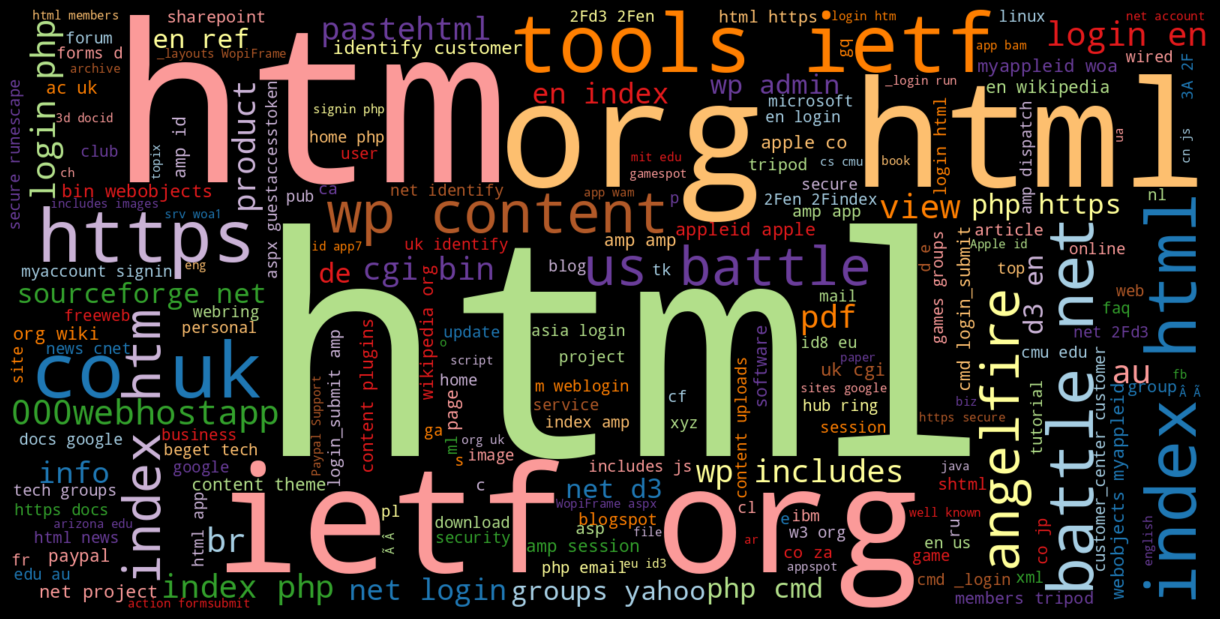

In [8]:
phish_url = " ".join(i for i in df_phish.url)
wc = WordCloud(width = 1600, height = 800, colormap="Paired").generate(phish_url)
plt.figure(figsize = (12,14), facecolor = 'k')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


In [9]:
import re
def has_ip(url):
  match = re.search(
      '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url
  )
  if match:
    return 1
  else:
    return 0

df['use_of_ip'] = df['url'].apply(lambda i: has_ip(i))

In [10]:
from urllib.parse import urlparse

def abnormal(url):
  hostname = urlparse(url).hostname
  hostname = str(hostname)
  match = re.search(hostname,url)
  if match:
    return 1
  else:
    return 0
df['abnormal_url'] = df['url'].apply(lambda i: abnormal(i))

In [ ]:
#!pip install googlesearch-python

  Preparing metadata (setup.py) ... done
  Created wheel for googlesearch-python: filename=googlesearch_python-1.2.3-py3-none-any.whl size=4209 sha256=a768dc5cbb8680aff473af9c1552fb6893a19242eedf560da667a60b996dbeb3
  Stored in directory: /root/.cache/pip/wheels/98/24/e9/6c225502948c629b01cc895f86406819281ef0da385f3eb669
Successfully built googlesearch-python


In [11]:
from googlesearch import search


In [12]:
def gindex(url):
  site = search(url, 5)
  return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: gindex(i))

In [13]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [14]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):

    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0


df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [15]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))


In [16]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,...,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,...,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,...,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,...,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,...,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,...,1,0,1,1,3,235,23,0,22,199


In [17]:
!pip install tld

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.8/263.8 kB 2.2 MB/s eta 0:00:00


In [18]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [19]:
df = df.drop("tld",1)

<ipython-input-19-beaedf415f7f>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df = df.drop("tld",1)


In [20]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [21]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

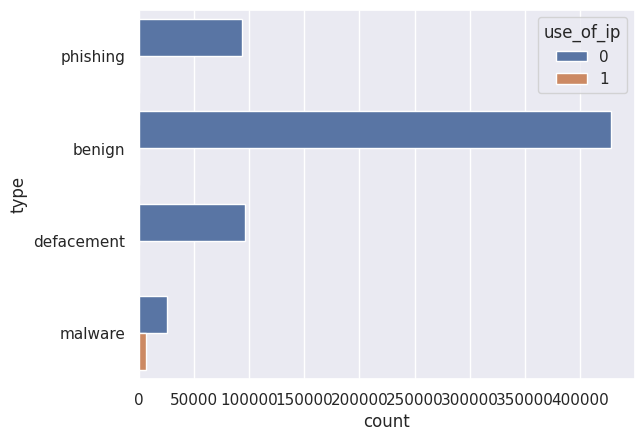

In [22]:
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="use_of_ip")

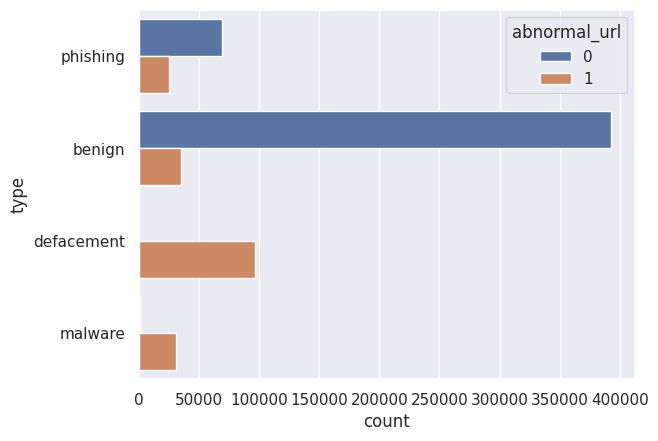

In [23]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="abnormal_url")

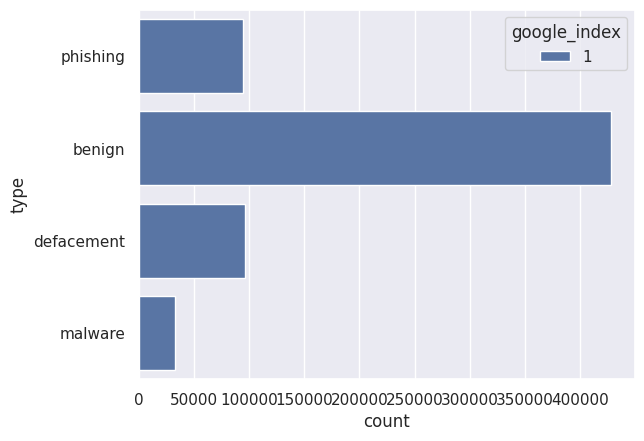

In [24]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="google_index")

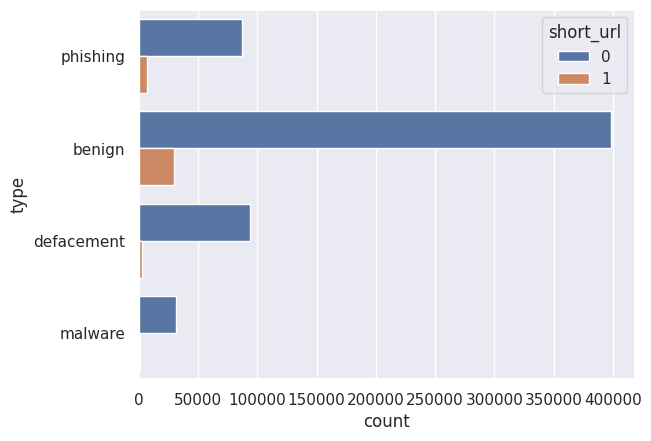

In [25]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="short_url")

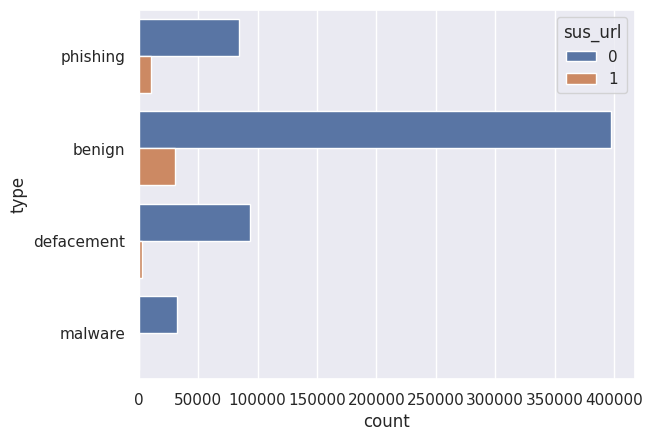

In [26]:
sns.set(style="darkgrid")
ax = sns.countplot(y="type", data=df,hue="sus_url")

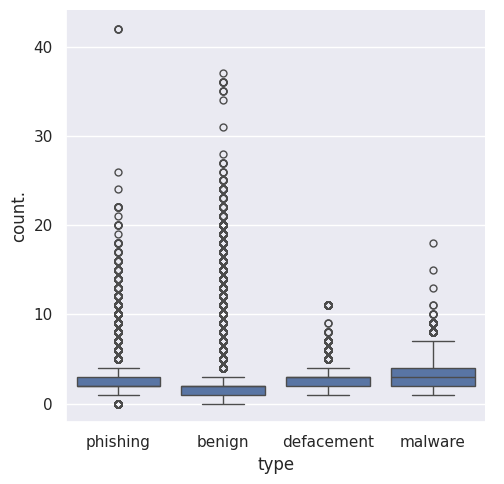

In [27]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count.", kind="box", data=df)

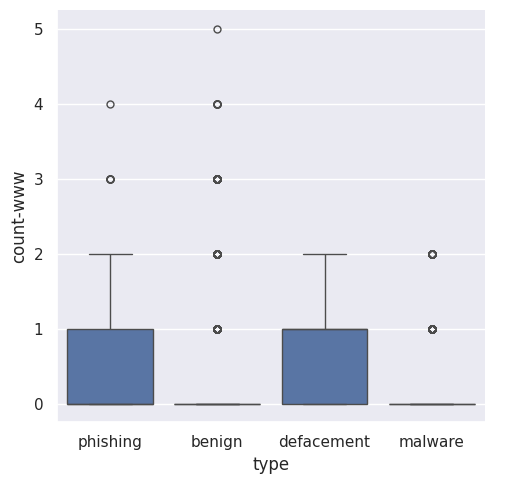

In [28]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count-www", kind="box", data=df)

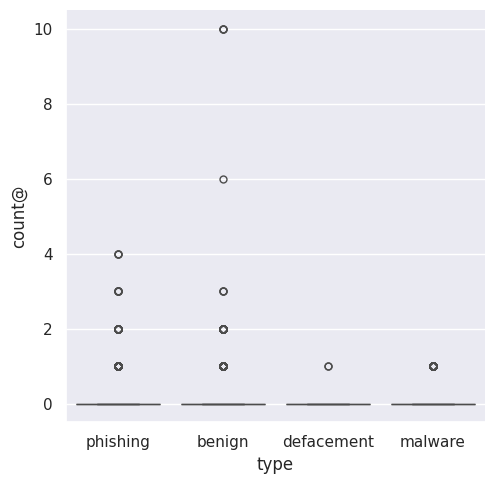

In [29]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count@", kind="box", data=df)

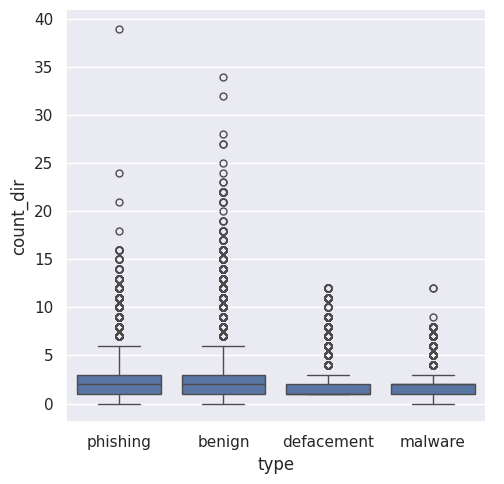

In [30]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="count_dir", kind="box", data=df)

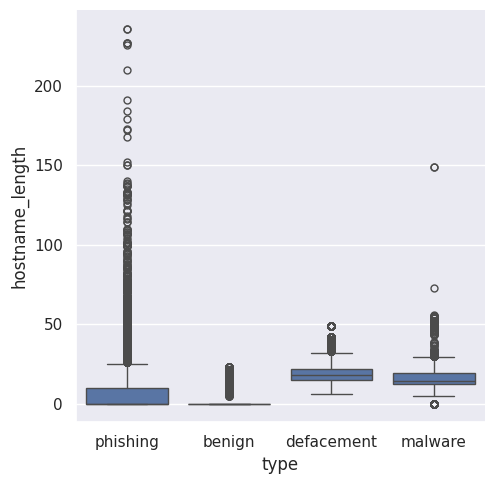

In [31]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="hostname_length", kind="box", data=df)

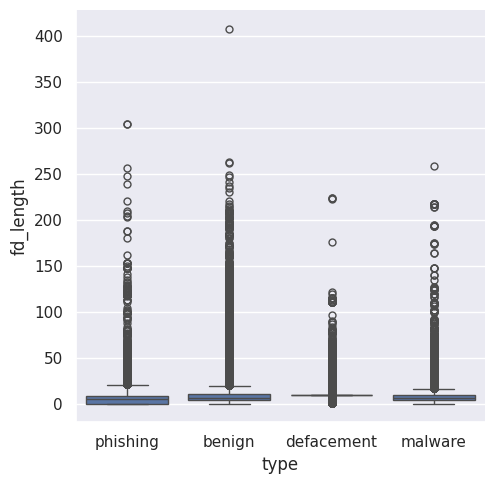

In [32]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="fd_length", kind="box", data=df)

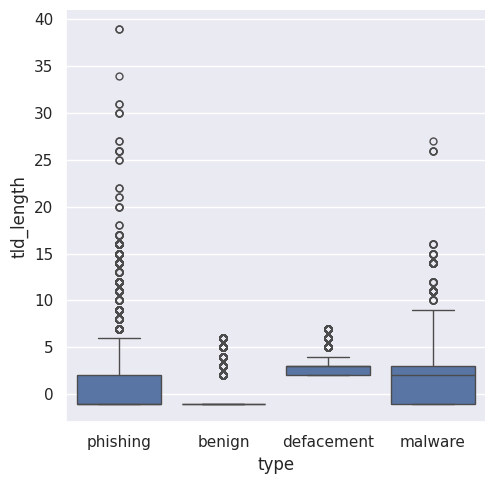

In [33]:
sns.set(style="darkgrid")
ax = sns.catplot(x="type", y="tld_length", kind="box", data=df)

In [24]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
df["type_code"] = lb_make.fit_transform(df["type"])
df["type_code"].value_counts()

0    428103
1     96457
3     94111
2     32520
Name: type_code, dtype: int64

In [63]:
label_mapping = {
    0:0,
    1:1,
    2:1,
    3:1
}

df["type_code"] = df["type_code"].map(label_mapping)

In [64]:

#Predictor Variables
# filtering out google_index as it has only 1 value
X = df[['use_of_ip','abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters']]

#Target Variable
y = df['type_code']

In [26]:
X.head()

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
0,0,0,2,0,0,0,0,0,0,0,...,0,1,0,16,0,0,0,-1,0,13
1,0,0,2,0,0,2,0,0,0,0,...,0,0,0,35,0,0,5,-1,1,29
2,0,0,2,0,0,3,0,0,0,0,...,0,0,0,31,0,0,7,-1,1,25
3,0,1,3,1,0,1,0,0,0,1,...,1,1,4,88,21,0,9,2,7,63
4,0,1,2,0,0,1,0,0,0,1,...,1,1,3,235,23,0,9,3,22,199


In [27]:
X.columns

Index(['use_of_ip', 'abnormal_url', 'count.', 'count-www', 'count@',
       'count_dir', 'count_embed_domian', 'short_url', 'count-https',
       'count-http', 'count%', 'count?', 'count-', 'count=', 'url_length',
       'hostname_length', 'sus_url', 'fd_length', 'tld_length', 'count-digits',
       'count-letters'],
      dtype='object')

In [28]:
X.shape

(651191, 21)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2,shuffle=True, random_state=5)

In [30]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [66]:
y_train

341912    1
102663    0
219118    0
527805    1
239050    0
         ..
197766    1
443597    0
528447    1
457452    0
405974    0
Name: type_code, Length: 520952, dtype: int64

Random Forest Classifier

In [32]:


# Import the module
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=20,max_features='sqrt')
rf.fit(X_train_resampled,y_train_resampled)
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test,y_pred_rf,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.98      0.96      0.97     85621
  defacement       0.98      0.99      0.99     19292
    phishing       0.96      0.95      0.96      6504
     malware       0.82      0.90      0.86     18822

    accuracy                           0.96    130239
   macro avg       0.94      0.95      0.94    130239
weighted avg       0.96      0.96      0.96    130239

accuracy:   0.955


In [41]:


# Calculate and print the accuracy score
score = metrics.accuracy_score(y_test, y_pred_rf)
print("accuracy:   %0.3f" % score)

accuracy:   0.956


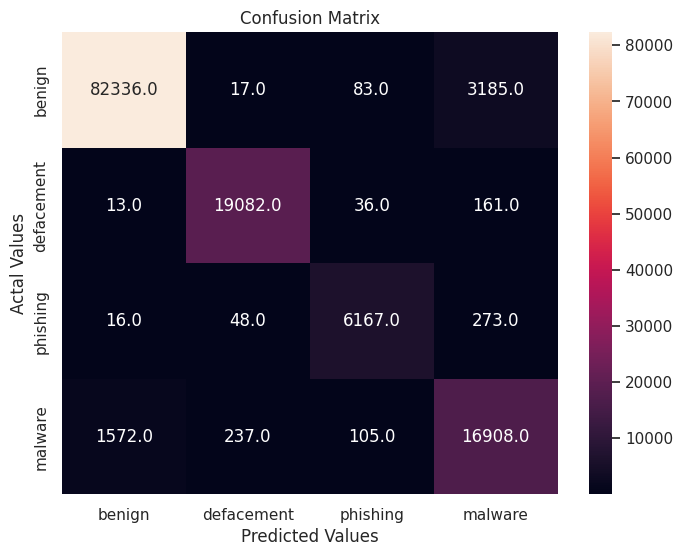

In [42]:
cm = confusion_matrix(y_test, y_pred_rf)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'],
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

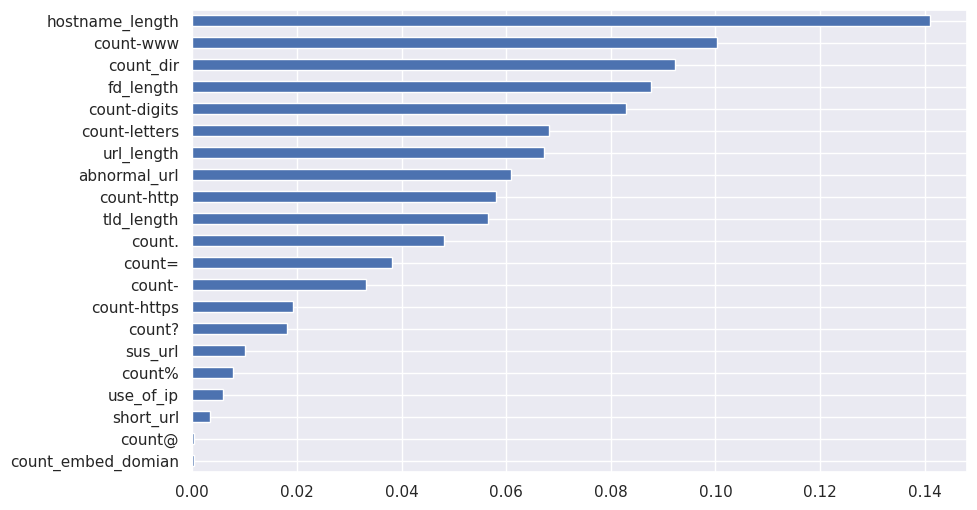

In [43]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

Light GBM

In [44]:
lgb = LGBMClassifier(objective='multiclass',boosting_type= 'gbdt',n_jobs = 5,
          silent = True, random_state=5)
LGB_C = lgb.fit(X_train_resampled, y_train_resampled)


y_pred_lgb = LGB_C.predict(X_test)
print(classification_report(y_test,y_pred_lgb,target_names=['benign', 'defacement','phishing','malware']))

score = metrics.accuracy_score(y_test, y_pred_lgb)
print("accuracy:   %0.3f" % score)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.150565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 1369928, number of used features: 21
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] Unknown parameter: silent
              precision    recall  f1-score   support

      benign       0.98      0.95      0.96     85621
  defacement       0.96      0.98      0.97     19292
    phishing       0.92      0.93      0.92      6504
     malware       0.78      0.88      0.82     18822

    accuracy    

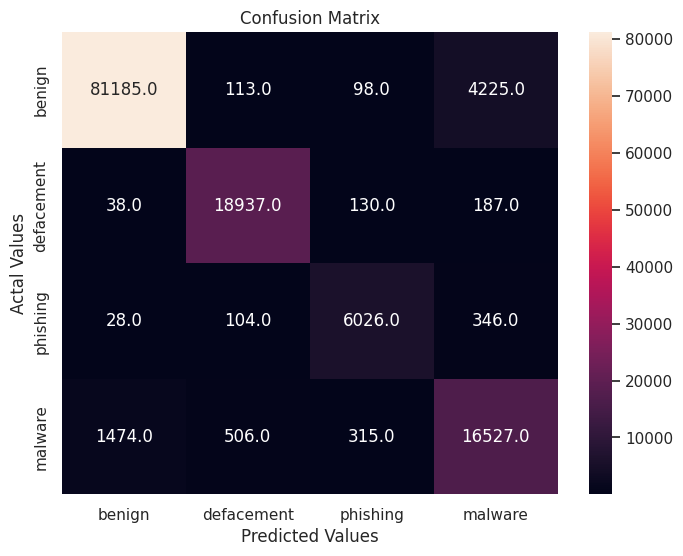

In [45]:
cm = confusion_matrix(y_test, y_pred_lgb)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'],
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

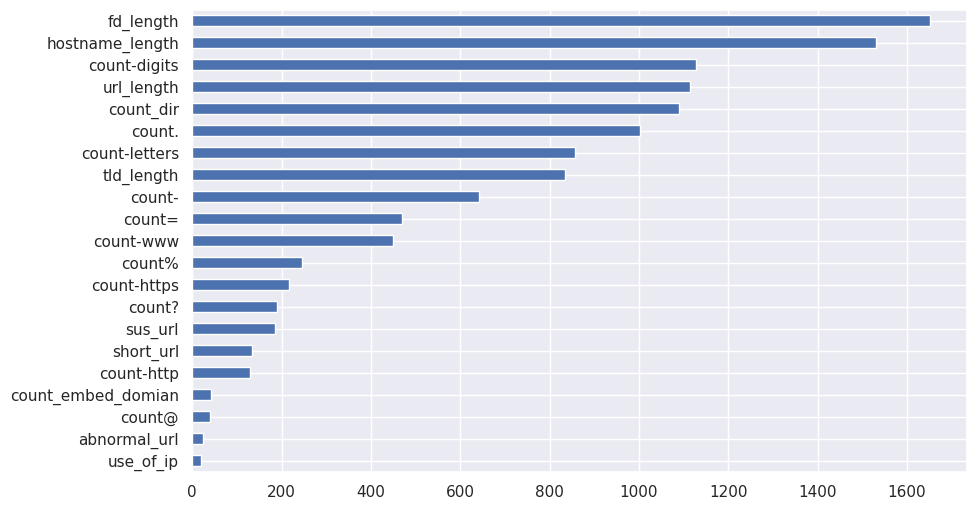

In [46]:
feat_importances = pd.Series(lgb.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

XGBoost

In [55]:
xgb_c = xgb.XGBClassifier(n_estimators= 100)
xgb_c.fit(X_train_resampled,y_train_resampled)
y_pred_x = xgb_c.predict(X_test)
print(classification_report(y_test,y_pred_x,target_names=['benign', 'defacement','phishing','malware']))


score = metrics.accuracy_score(y_test, y_pred_x)
print("accuracy:   %0.3f" % score)

              precision    recall  f1-score   support

      benign       0.98      0.95      0.97     85621
  defacement       0.97      0.99      0.98     19292
    phishing       0.94      0.94      0.94      6504
     malware       0.79      0.89      0.84     18822

    accuracy                           0.95    130239
   macro avg       0.92      0.94      0.93    130239
weighted avg       0.95      0.95      0.95    130239

accuracy:   0.947


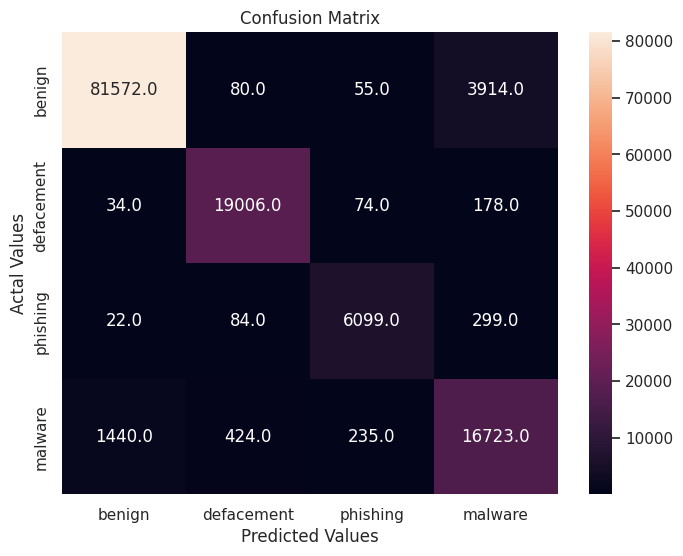

In [48]:
cm = confusion_matrix(y_test, y_pred_x)
cm_df = pd.DataFrame(cm,
                     index = ['benign', 'defacement','phishing','malware'],
                     columns = ['benign', 'defacement','phishing','malware'])
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True,fmt=".1f")
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

<Axes: >

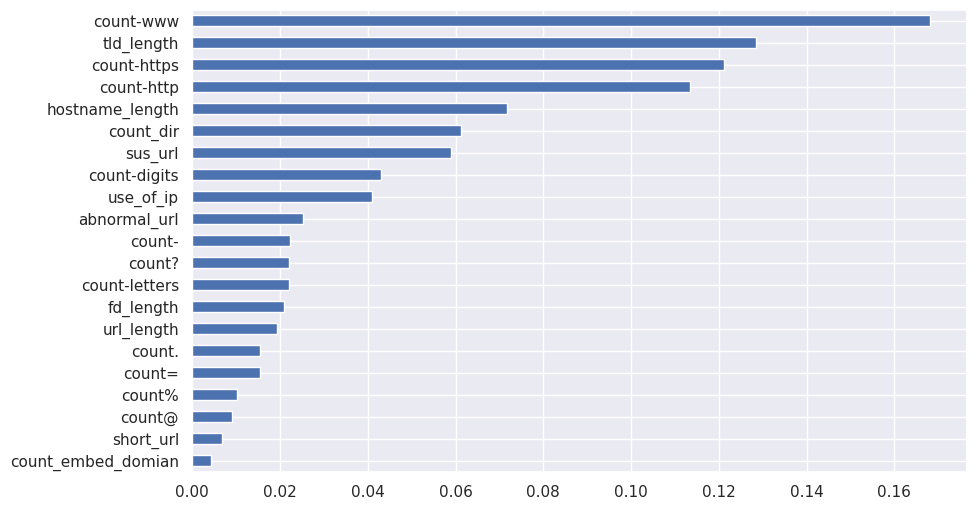

In [49]:
feat_importances = pd.Series(xgb_c.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind="barh",figsize=(10, 6))

In [33]:
!pip install tensorflow

In [41]:
X_train

,use_of_ip,abnormal_url,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,...,count?,count-,count=,url_length,hostname_length,sus_url,fd_length,tld_length,count-digits,count-letters
209860,0,1,3,1,0,1,0,0,0,1,...,1,0,1,36,13,0,8,3,3,24
124821,0,0,2,0,0,2,0,0,0,0,...,0,0,0,26,0,0,5,-1,7,15
539292,0,1,4,0,0,1,0,0,0,1,...,0,0,0,35,21,0,6,-1,17,9
224836,0,1,3,1,0,1,0,0,0,1,...,1,6,4,108,19,0,9,3,19,66
161897,0,1,2,0,0,1,0,0,1,2,...,1,1,1,283,11,0,4,3,82,122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175524,0,0,3,0,0,1,0,0,0,0,...,0,0,0,28,0,0,14,-1,0,23
82780,0,1,1,0,0,3,0,0,0,1,...,0,7,0,92,13,0,20,3,0,78
7416,0,0,1,0,0,2,0,0,0,0,...,0,1,0,34,0,0,5,-1,0,30
264781,0,0,2,0,0,2,0,0,0,0,...,0,0,0,48,0,0,4,-1,0,40


In [43]:
y_train

209860    1
124821    0
539292    2
224836    1
161897    0
         ..
175524    0
82780     0
7416      0
264781    0
305564    0
Name: type_code, Length: 520952, dtype: int64

In [71]:
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential()

# Fully connected layers
model.add(layers.Dense(128, activation='relu', input_shape=(21,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# Output layer with softmax activation for multi-class classification
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with 4 neurons for multi-class classification

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Summary of the model architecture
model.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 128)               2816      
                                                                 
 dense_24 (Dense)            (None, 64)                8256      
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 13185 (51.50 KB)
Trainable params: 13185 (51.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
# Define the number of epochs and batch size
epochs = 5
batch_size = 32

# Fit the model to the training data
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/5
13024/13024 [==============================] - 61s 4ms/step - loss: 0.1631 - accuracy: 0.9425 - val_loss: 0.1263 - val_accuracy: 0.9581
Epoch 2/5
13024/13024 [==============================] - 59s 4ms/step - loss: 0.1231 - accuracy: 0.9586 - val_loss: 0.1177 - val_accuracy: 0.9594
Epoch 3/5
13024/13024 [==============================] - 55s 4ms/step - loss: 0.1146 - accuracy: 0.9613 - val_loss: 0.1123 - val_accuracy: 0.9629
Epoch 4/5
13024/13024 [==============================] - 59s 5ms/step - loss: 0.1094 - accuracy: 0.9632 - val_loss: 0.1114 - val_accuracy: 0.9618
Epoch 5/5
13024/13024 [==============================] - 59s 5ms/step - loss: 0.1065 - accuracy: 0.9641 - val_loss: 0.1025 - val_accuracy: 0.9652


Prediction

In [48]:
def main(url):

    status = []

    status.append(has_ip(url))
    status.append(abnormal(url))
    status.append(count_dot(url))
    status.append(count_www(url))
    status.append(count_atrate(url))
    status.append(no_of_dir(url))
    status.append(no_of_embed(url))

    status.append(shortening_service(url))
    status.append(count_https(url))
    status.append(count_http(url))

    status.append(count_per(url))
    status.append(count_ques(url))
    status.append(count_hyphen(url))
    status.append(count_equal(url))

    status.append(url_length(url))
    status.append(hostname_length(url))
    status.append(suspicious_words(url))
    status.append(digit_count(url))
    status.append(letter_count(url))
    status.append(fd_length(url))
    tld = get_tld(url,fail_silently=True)

    status.append(tld_length(tld))




    return status

In [73]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))



    pred = model.predict(features_test)
    print(pred)
    if int(pred[0]) == 0:

        res="SAFE"
        return res
    elif int(pred[0]) == 1.0:

        res="DEFACEMENT"
        return res
    elif int(pred[0]) == 2.0:
        res="PHISHING"
        return res

    elif int(pred[0]) == 3.0:

        res="MALWARE"
        return res

In [77]:
from sklearn.linear_model import Perceptron
model1 = Perceptron()
model1.fit(X_train, y_train)

Perceptron()

In [80]:
def get_prediction_from_url(test_url):
    features_test = main(test_url)
    # Due to updates to scikit-learn, we now need a 2D array as a parameter to the predict function.
    features_test = np.array(features_test).reshape((1, -1))

    pred = model1.predict(features_test)
    # Assuming the model outputs probabilities for the positive class (malware)
    # You may need to adjust this if your model outputs probabilities differently
    malware_prob = pred[0]
    print(pred)

    # Set a threshold for classification (e.g., 0.5)
    threshold = 0.5

    if malware_prob >= threshold:
        res = "MALWARE"
    else:
        res = "SAFE"

    return res


In [83]:
urls = ['amazon.com','vit.ac.in']
for url in urls:
     print(get_prediction_from_url(url))

[0]
SAFE
[0]
SAFE


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but Perceptron was fitted with feature names
  warnings.warn(
